In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

from functions import transform_raw_data, clean_df, impute_fit_df, impute_transform_df

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

In [2]:
features = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'vehicle_type','junction_detail','towing_and_articulation','vehicle_manoeuvre',
            'casualty_imd_decile','pedestrian_crossing_physical_facilities','pedestrian_crossing_human_control','driver_imd_decile',
            'day_of_week','time_period','season',
            'first_road_class','road_type','speed_limit','junction_control','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','propulsion_code','sex_of_casualty','vehicle_subtype',
            'urban_or_rural_area','casualty_home_area_type','lsoa_of_casualty','first_point_of_impact','junction_location']
target = 'casualty_severity'

In [53]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
df = df[features + [target]]
df = clean_df(df)
categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler = impute_fit_df(df)
df = impute_transform_df(df, categorical_freqs, vars_to_groupby,
                         continuous_medians_grouped, continuous_medians, scaler, df.columns,
                         one_hot_encode=False)

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


In [5]:
# plotting correlation between features and the target
def is_continuous(series):
    return pd.api.types.is_numeric_dtype(series)

# function assumes that continuous variables are listed before categorical columns in the 'columns' input
def plot_correlation_grid(df, features, num_cols=3):
    num_plots = len(features)
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 30))
    ax = ax.flatten()
    
    # get all pairs of variables to plot
    plotted_pairs = 0
    max_plots = num_rows * num_cols

    # trimming category labels to make the charts easier to read
    df_trimmed = df.applymap(lambda x: x[:20] if isinstance(x, str) else x)
    
    for i, feature in enumerate(features):

        ax_sub = ax[plotted_pairs]
        
        # if both variables are continuous, create a scatter plot
        if is_continuous(df_trimmed[feature]) and not is_continuous(df_trimmed[target]):
            sns.boxplot(x=df_trimmed[target], y=df_trimmed[feature], ax=ax_sub)
        else:
            # converting categories to ordinal integers
            ord_enc = OrdinalEncoder()
            enc_df = pd.DataFrame(ord_enc.fit_transform(df_trimmed[[feature, target]]), columns=[feature, target])

            # Generate the random noise
            # The noise is in the range 0 to 0.5
            xnoise, ynoise = np.random.random(len(df_trimmed)) / 2, np.random.random(len(df_trimmed)) / 2

            # Plot the scatterplot
            ax_sub.scatter(enc_df[feature] + xnoise, enc_df[target] + ynoise, alpha=0.5)
            # setting xticks and yticks to be category names
            # centre of noise will be around 0.25, and ordinal integers increase by 1
            ax_sub.set_xticks([i + 0.25 for i in range(len(ord_enc.categories_[0]))], ord_enc.categories_[0]) 
            ax_sub.set_yticks([i + 0.25 for i in range(len(ord_enc.categories_[1]))], ord_enc.categories_[1])

            ax_sub.grid()
            sns.despine(left=True, bottom=True, ax=ax_sub)

        ax_sub.set_title(f'{feature} vs {target}')
        ax_sub.xaxis.set_ticks(ax_sub.get_xticks()) # add this line to avoid warning
        ax_sub.set_xticklabels(ax_sub.get_xticklabels(), rotation=45, ha='right')
        plotted_pairs += 1
                
        if plotted_pairs >= max_plots:
            break

    for j in range(num_rows * num_cols):
        if j > plotted_pairs - 1:
            fig.delaxes(ax[j])
    
    plt.tight_layout()
    plt.show()

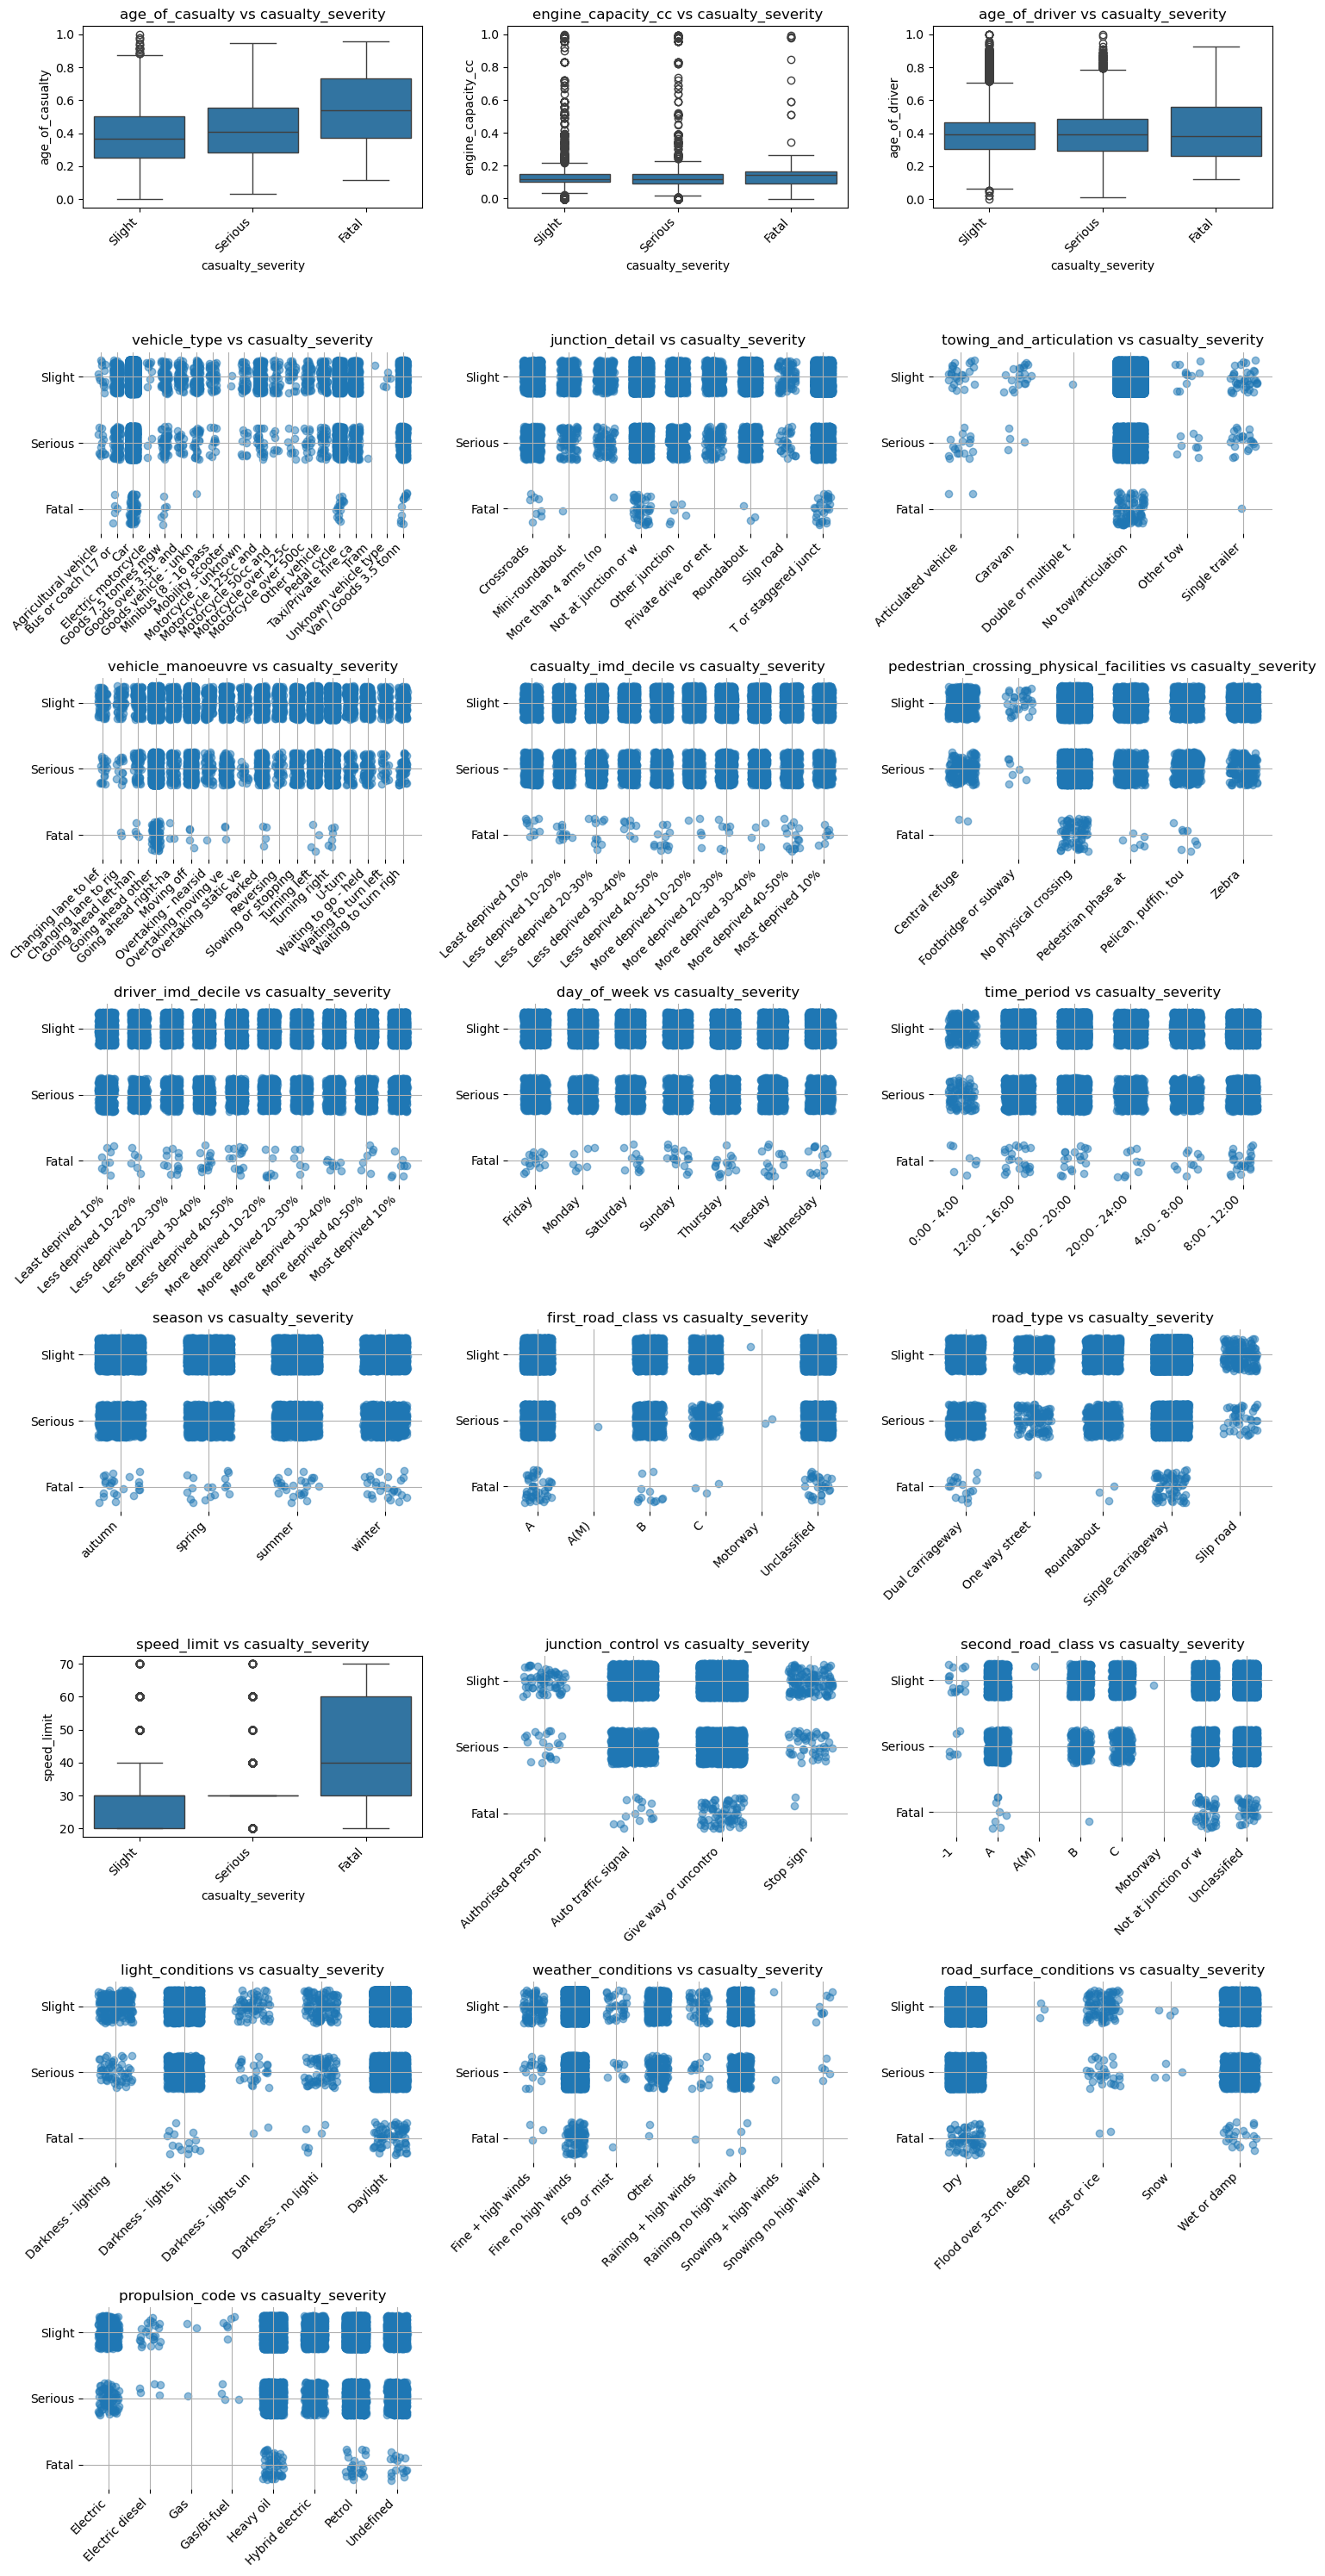

In [58]:
plot_correlation_grid(df, features)

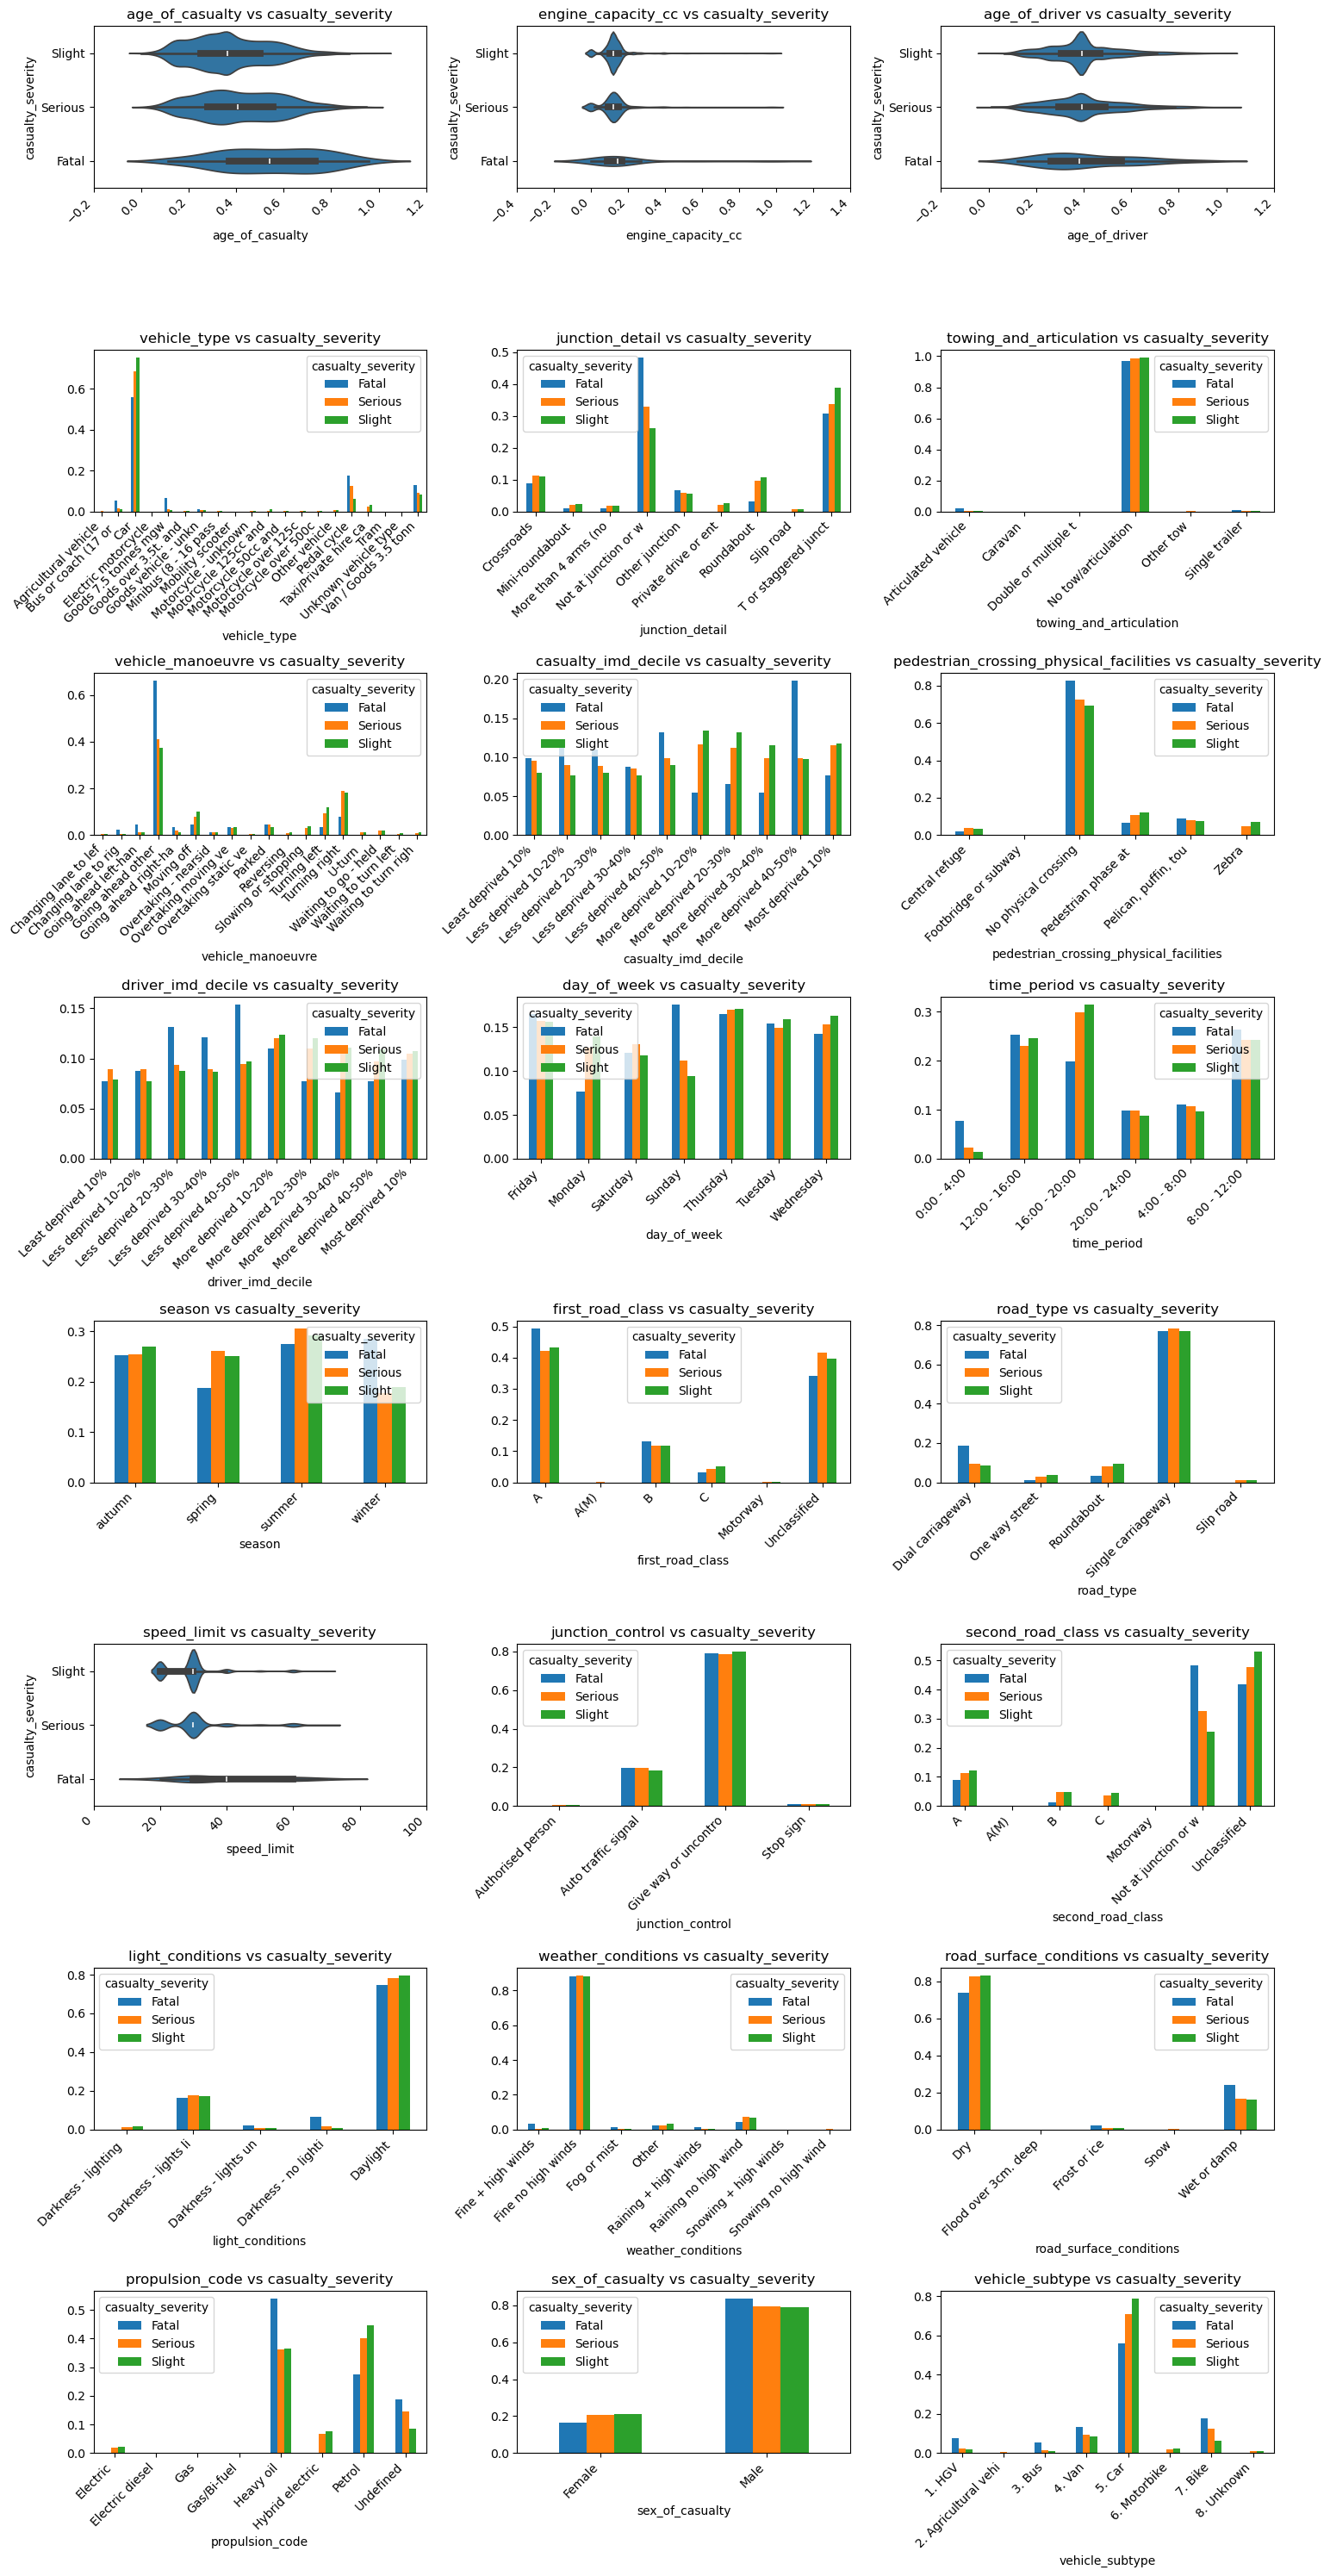

In [55]:
# correlation plots after resampling with SMOTE
categorical_features = [col for col in df.select_dtypes(include='object').columns.to_list() if col in features]

plot_correlation_grid(df, features)

In [6]:
features = ['day_of_week','time_period','first_road_class','road_type','speed_limit','junction_detail','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','vehicle_type','age_of_casualty','pedestrian_crossing_physical_facilities',
            #'T2M','RH2M','PRECTOTCORR','WS2M','log_PRECTOTCORR',
            'vehicle_subtype']
target = 'casualty_severity'

In [7]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
df = df[features + [target]]
df = clean_df(df)
categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler = impute_fit_df(df)
df = impute_transform_df(df, categorical_freqs, vars_to_groupby,
                         continuous_medians_grouped, continuous_medians, scaler, df.columns,
                         one_hot_encode=False)

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


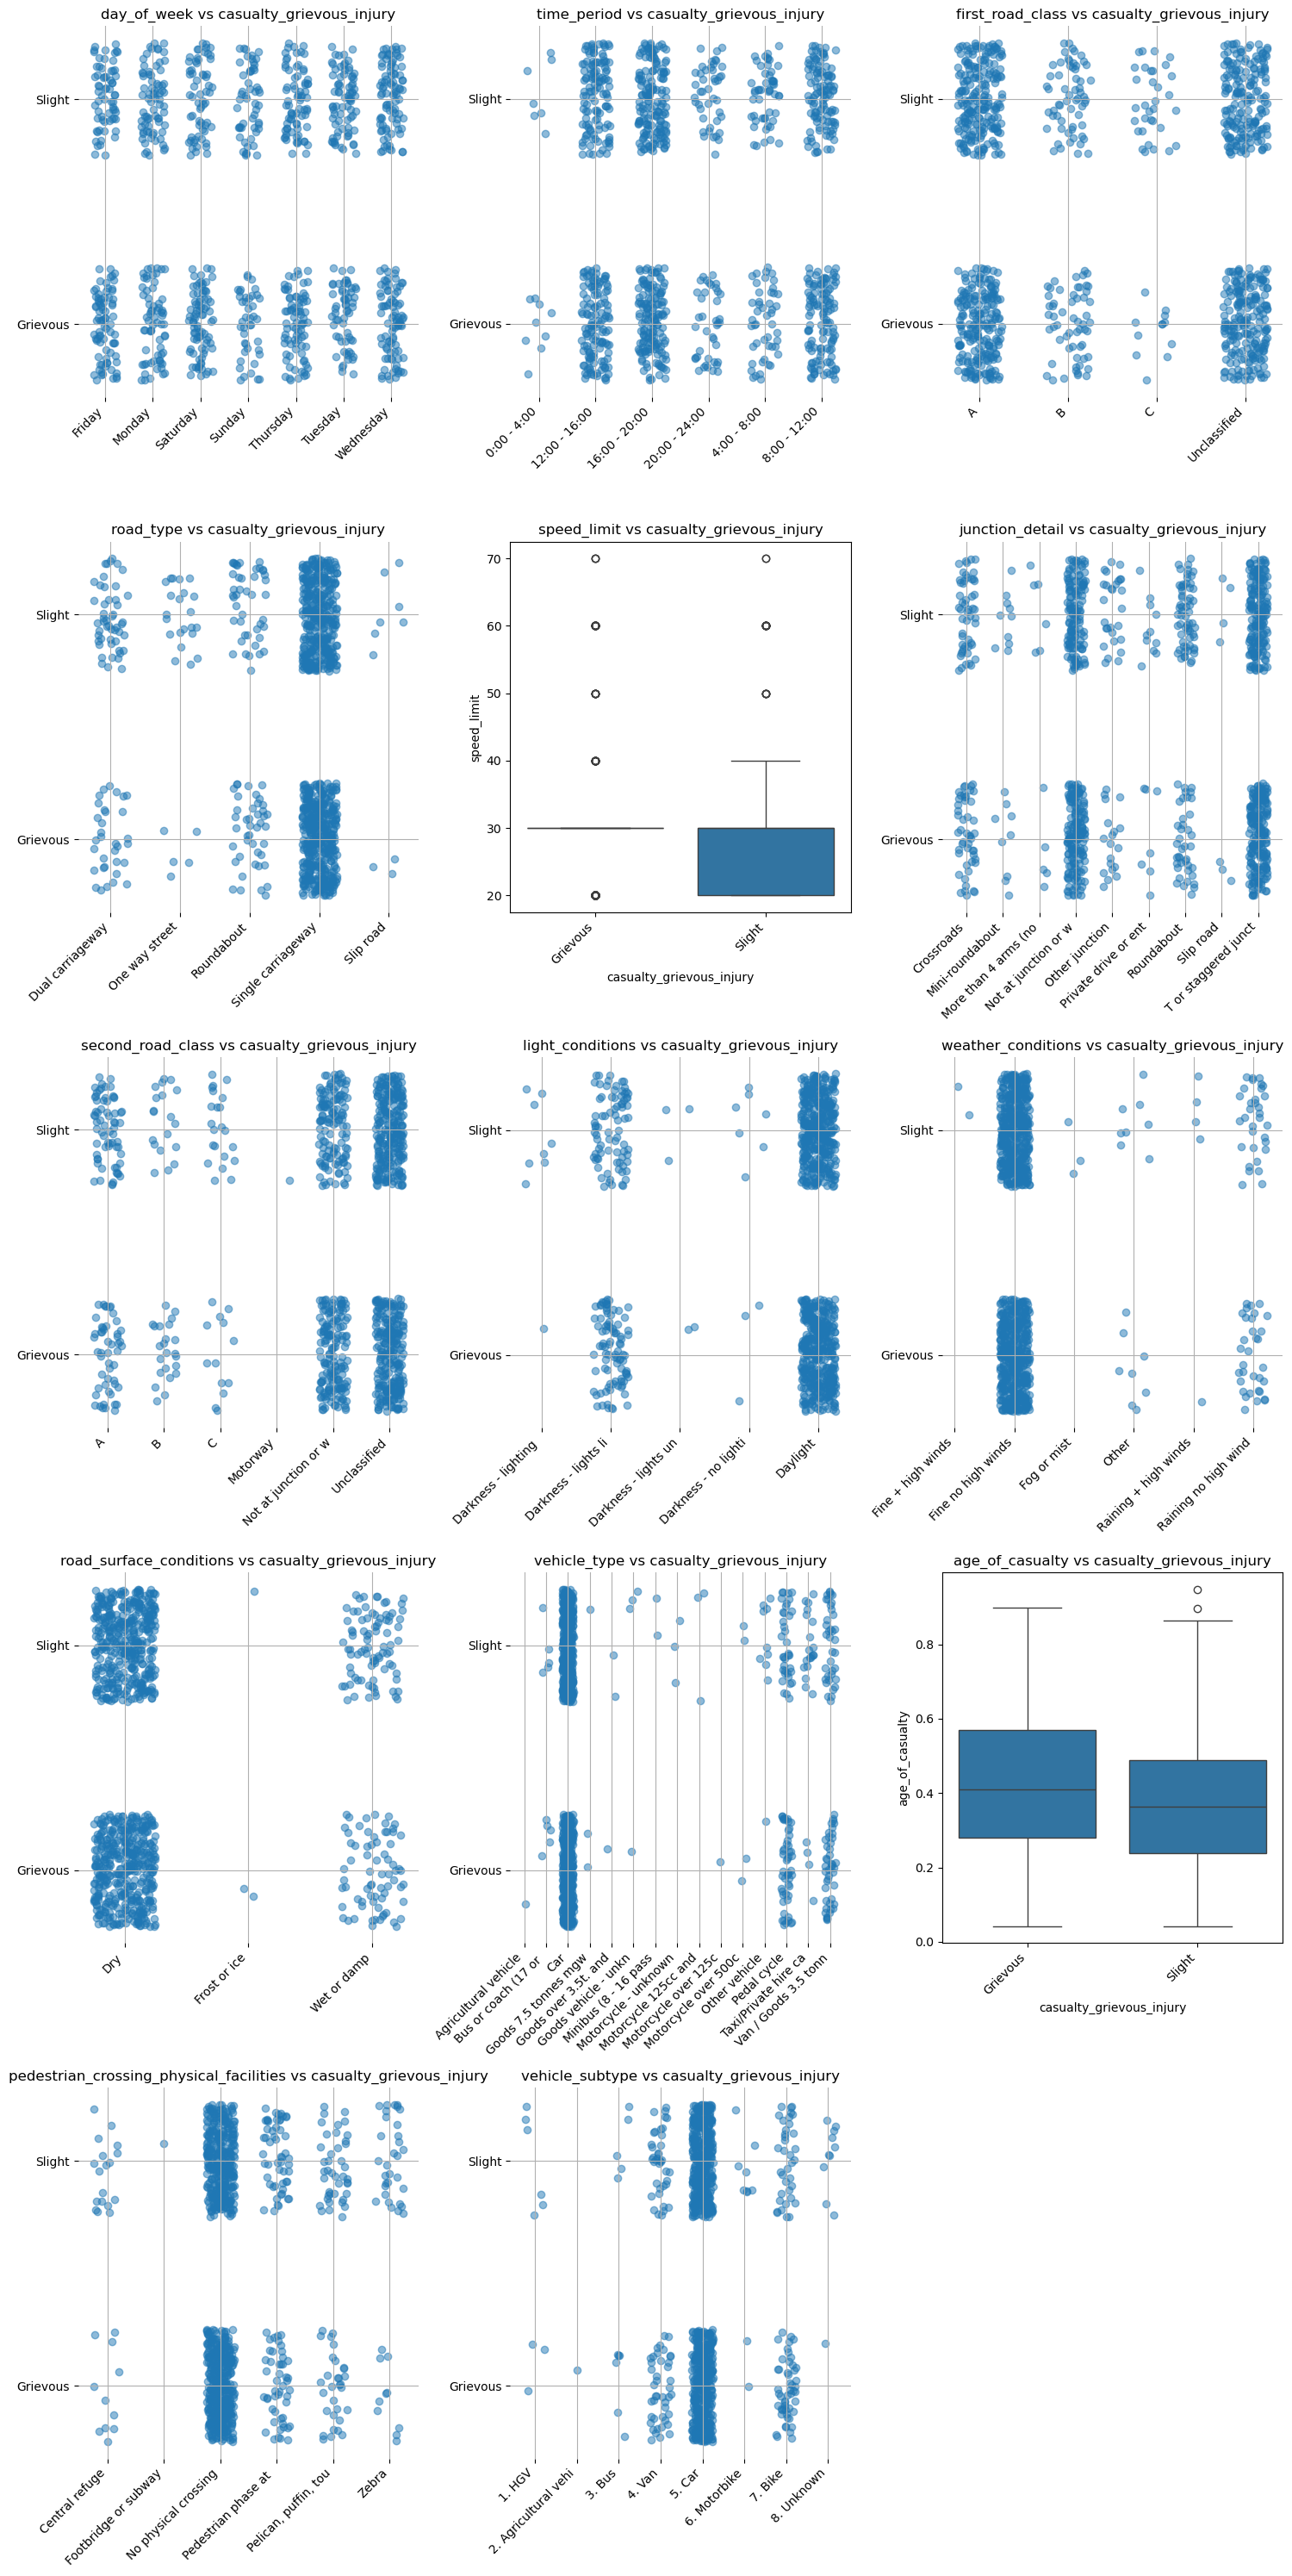

In [8]:
df['casualty_grievous_injury'] = np.where(df['casualty_severity'] == "Slight", "Slight", "Grievous")
# df["log_PRECTOTCORR"] = np.log(df["PRECTOTCORR"] + 0.001)
target = 'casualty_grievous_injury'

# correlation plots after resampling with SMOTE
categorical_features = [col for col in df.select_dtypes(include='object').columns.to_list() if col in features]
pipeline = Pipeline([
    ('over', SMOTENC(categorical_features=categorical_features, sampling_strategy='not majority')),
    ('under', RandomUnderSampler(sampling_strategy={'Slight': 500, 'Grievous': 500}))
])
X_resampled, y_resampled = pipeline.fit_resample(df[features], df[target])
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

plot_correlation_grid(df_resampled, features)

In [46]:
# function assumes that continuous variables are listed before categorical columns in the 'columns' input
def plot_correlation_grid(df, features, num_cols=3):
    num_plots = len(features)
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 30))
    ax = ax.flatten()
    
    # get all pairs of variables to plot
    plotted_pairs = 0
    max_plots = num_rows * num_cols

    # trimming category labels to make the charts easier to read
    df_trimmed = df.applymap(lambda x: x[:20] if isinstance(x, str) else x)
    
    for feature in features:

        ax_sub = ax[plotted_pairs]
        
        # if both variables are continuous, create a scatter plot
        if is_continuous(df_trimmed[feature]) and not is_continuous(df_trimmed[target]):
            sns.violinplot(df_trimmed, x=feature, y=target, ax=ax_sub)
        else:
            df_trimmed.groupby(target)[feature].value_counts(normalize=True).unstack().transpose().plot(kind='bar', ax=ax_sub)

        ax_sub.set_title(f'{feature} vs {target}')
        ax_sub.xaxis.set_ticks(ax_sub.get_xticks()) # add this line to avoid warning
        ax_sub.set_xticklabels(ax_sub.get_xticklabels(), rotation=45, ha='right')
        plotted_pairs += 1
                
        if plotted_pairs >= max_plots:
            break

    for j in range(num_rows * num_cols):
        if j > plotted_pairs - 1:
            fig.delaxes(ax[j])
    
    plt.tight_layout()
    plt.show()

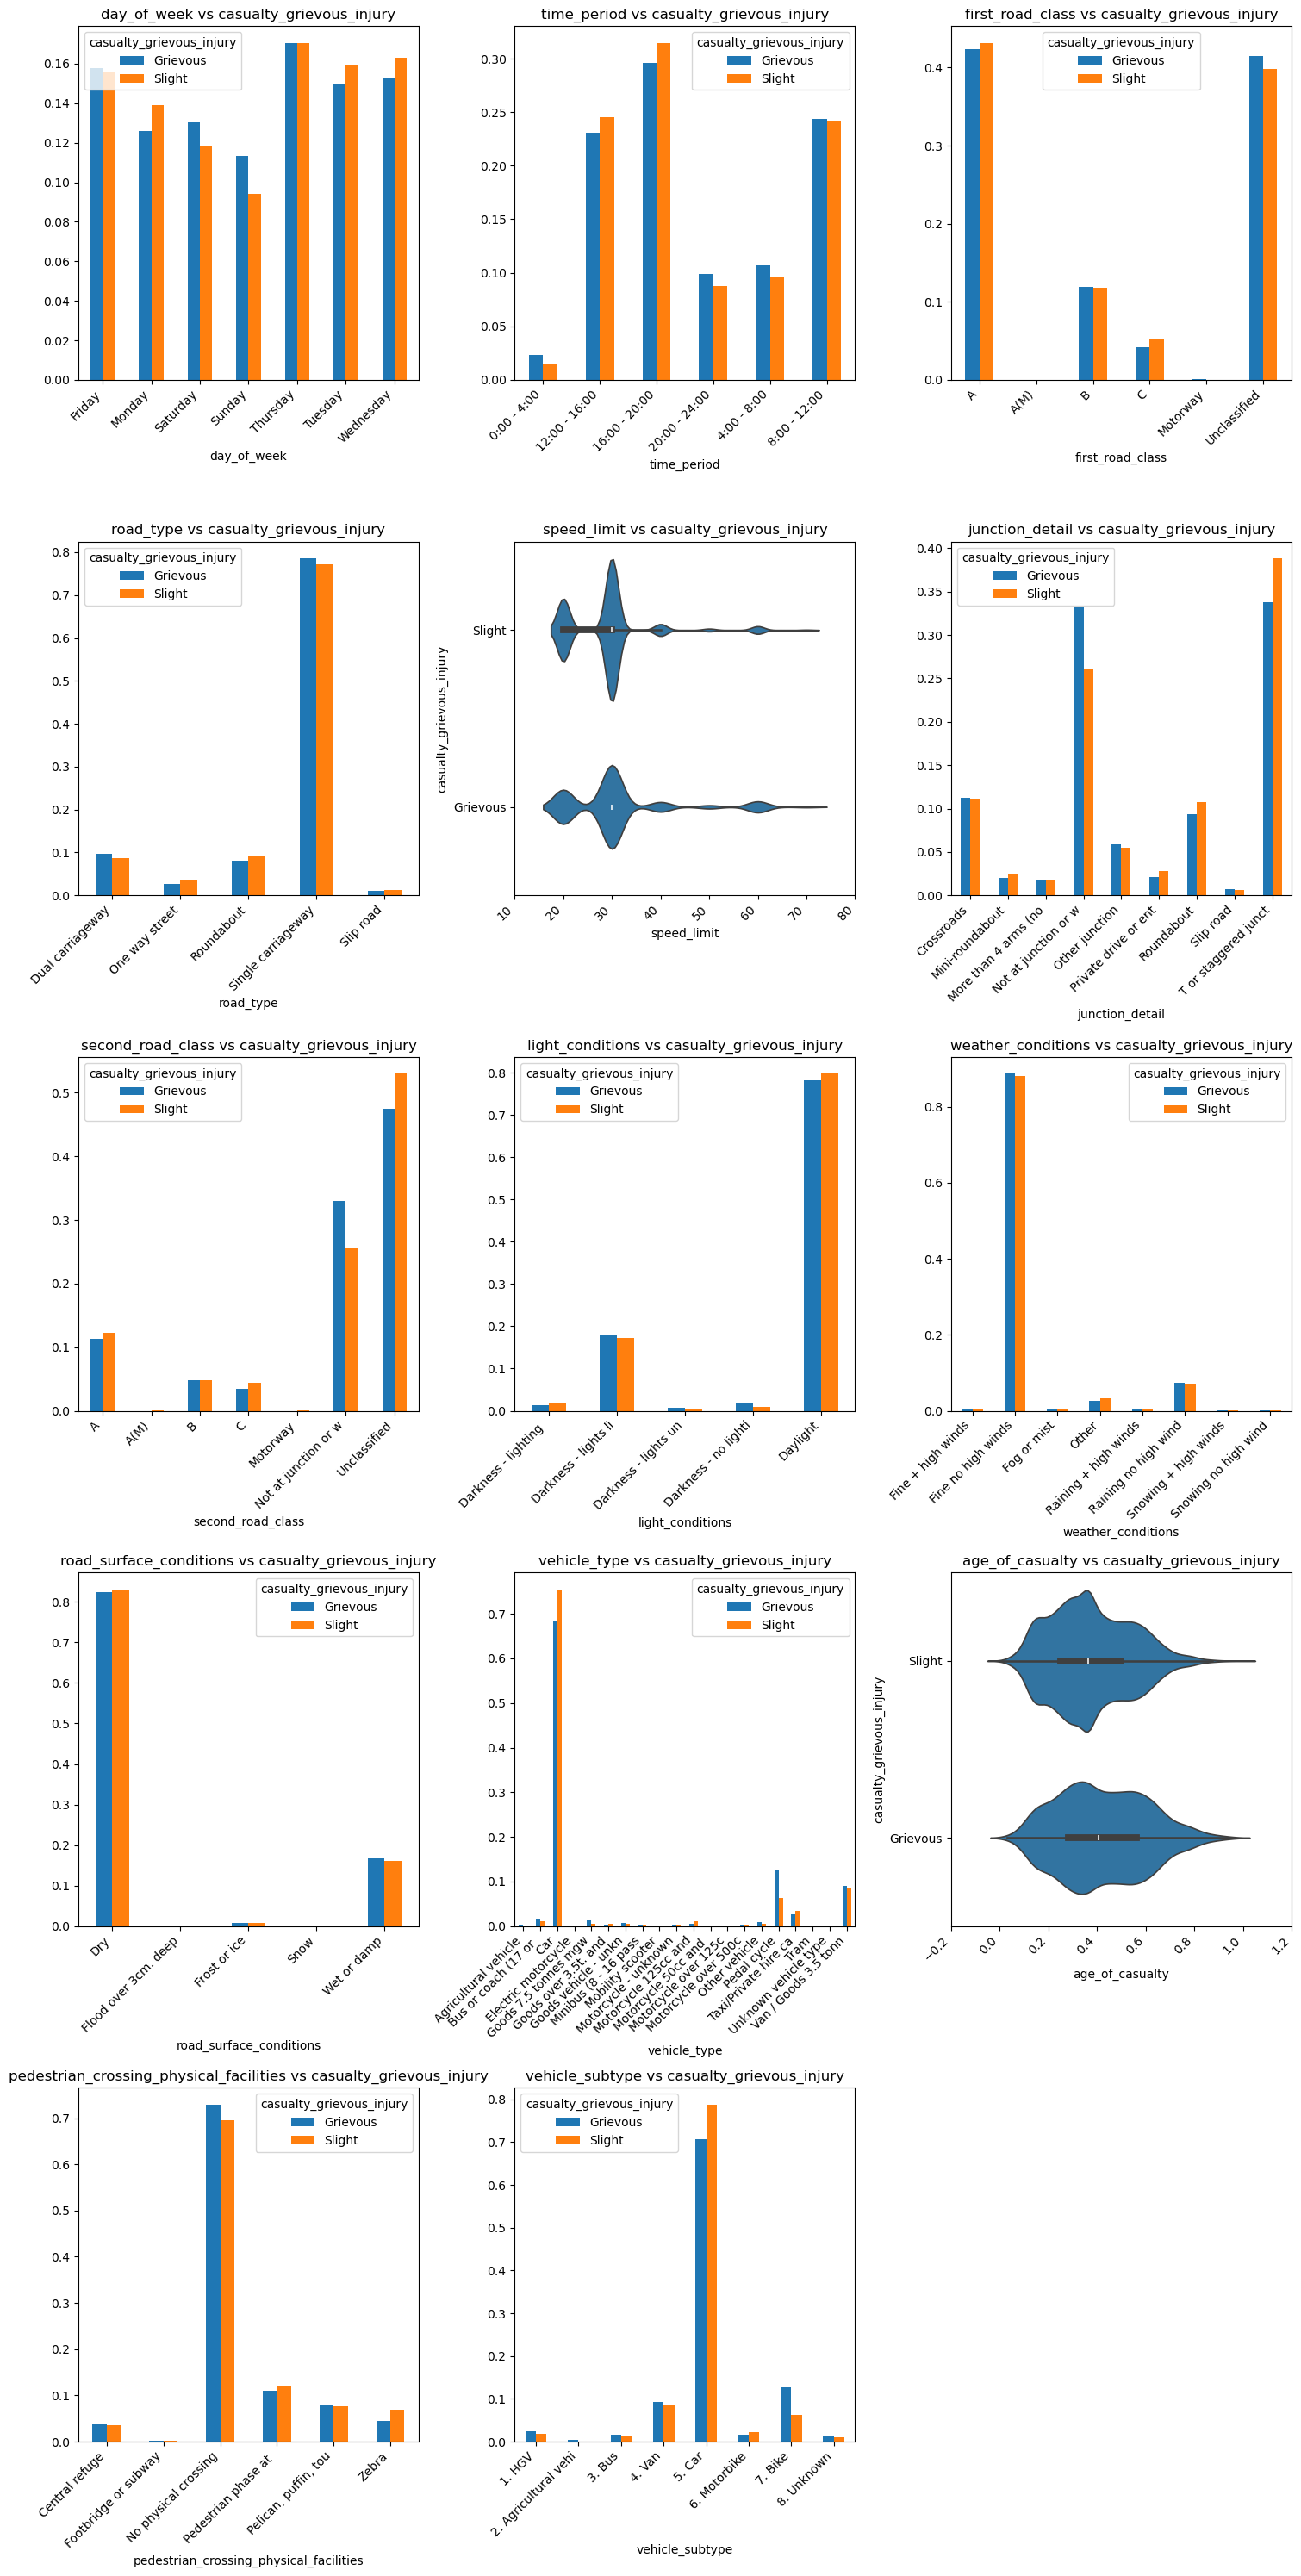

In [47]:
categorical_features = [col for col in df.select_dtypes(include='object').columns.to_list() if col in features]
plot_correlation_grid(df, features)